## Import Images

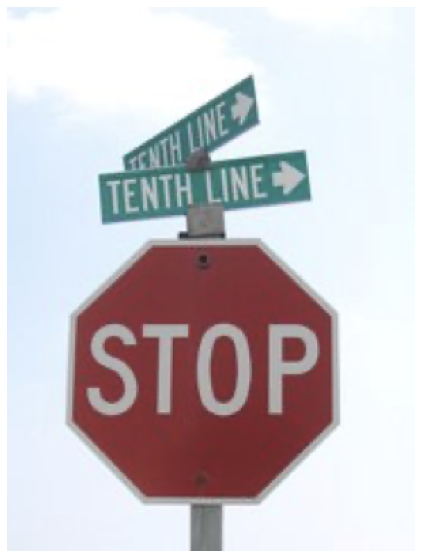

In [3]:
#!/bin/python3

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# First 51 imgs are semaphores
def importImage(no):
    return cv.imread('dataset/images/road' + str(no) + '.png', cv.IMREAD_COLOR)

def displayImage(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

displayImage(importImage(52))

## Export XML

In [4]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=["type"])

for i in range(0, 877):
    with open(f"dataset/annotations/road{i}.xml") as xml:
        tree = ET.parse(xml)
        root = tree.getroot()
        
        objects = root.findall("object")
        types = []
        for object in objects:
            types.append(object.find("name").text)

        df.loc[i] = ([types])

df.to_csv("dataset/signs.csv", index=False)

## Import XML

In [5]:
signs = pd.read_csv("dataset/signs.csv")

def typeToList(x):
    x["type"] = x["type"].replace("[", "")
    x["type"] = x["type"].replace("]", "")
    x["type"] = x["type"].replace("'", "")
    x["type"] = x["type"].strip()
    x["type"] = x["type"].split(", ")
    return x["type"]

signs["type"] = signs.apply(typeToList, axis=1)

def filterType(type):
    def filter(x):
        return len(set(x["type"]) & set(type)) != 0

    #print(signs.apply(filter, axis=1))
    return signs[signs.apply(filter, axis=1) == True]

filterType(["speedlimit"])

,type
100,[speedlimit]
101,[speedlimit]
102,[speedlimit]
103,[speedlimit]
104,[speedlimit]
...,...
871,[speedlimit]
872,"[speedlimit, stop]"
873,"[speedlimit, speedlimit, stop]"
874,"[speedlimit, speedlimit, stop]"


## Segmentação em áreas de interesse
Nesta secção iremos delimitar quais as áreas em que estamos interessados em analisar. Estas regiões correspondem às que contêm os sinais. Para isso iremos usar o colorspace HSV para filtrar as cores de interesse: **azul** e **vermelho**


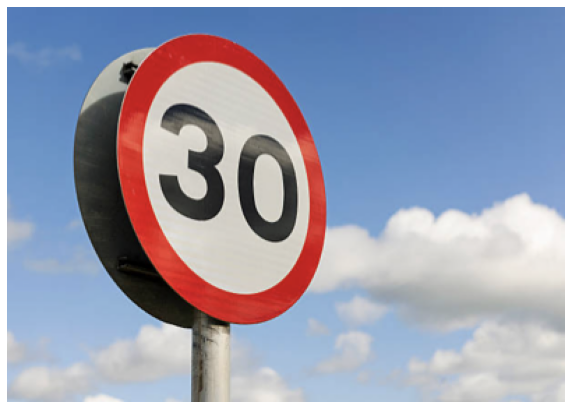

In [33]:
testImages = {"speedlimit": (7, 19, 20, 70)}
speedLimitId = filterType(["speedlimit"]).index[20]
speedLimit = importImage(speedLimitId)
displayImage(speedLimit)

### Mean Shift
Usado para uniformizar cor da imagem

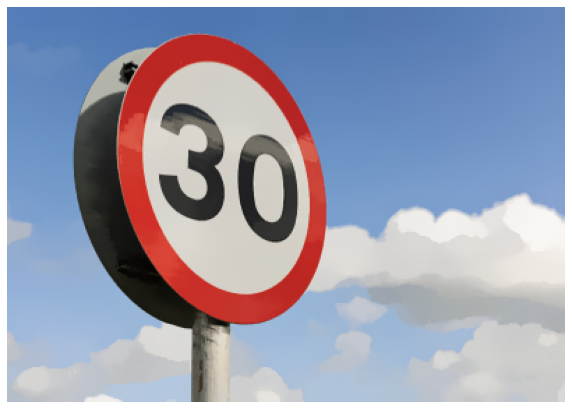

In [34]:
img = speedLimit

segmentedRoadImg = cv.pyrMeanShiftFiltering(img, 10, 15, 100)

displayImage(segmentedRoadImg)

### Filtro usando HSV
Utilizando as equações em TODO, podemos usar um threshold para selecionar apenas a regiões de forte saturação com fortes intensidades de vermelho ou azul.

/tmp/ipykernel_1874/425845389.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  hd_blue = 255 - abs(R - G) / (c_max - c_min)
/tmp/ipykernel_1874/425845389.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  hd_red = 255 - abs(G - B) / (c_max - c_min)


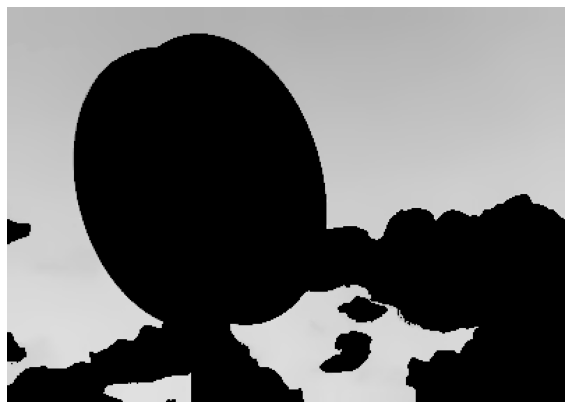

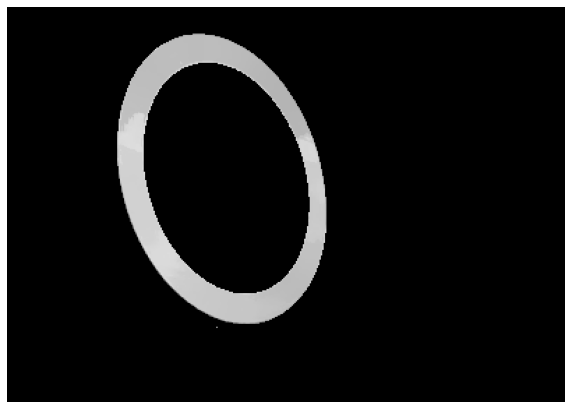

(None, None)

In [35]:
def splitColor(img):
    def calcScore(B, G, R):
        DIFF_TH = 30
        MIN_TH = 80
        c_max = max(R, G, B)
        c_min = min(R, G, B)

        if (c_max == B and (c_max - c_min) >= DIFF_TH):
            hd_blue = 255 - abs(R - G) / (c_max - c_min)
        else:
            hd_blue = 0

        if (c_max == R and (c_max - c_min) >= DIFF_TH):
            hd_red = 255 - abs(G - B) / (c_max - c_min)
        else:
            hd_red = 0

        if (c_max == 0):
            sd = 0
        else:
            sd = 255 - c_max
        
        hd_blue = 255 if hd_blue > MIN_TH else 0
        hd_red = 255 if hd_red > MIN_TH else 0
        return (hd_blue * sd, hd_red * sd)


    height, width = img.shape[0], img.shape[1]
    blank_image_b = np.zeros((height, width, 1), np.uint8)
    blank_image_r = np.zeros((height, width, 1), np.uint8)

    for i in range(height):
        for j in range(width):
            pixel = img[i, j]
            b, r = calcScore(*pixel)
            blank_image_b[i, j] = b
            blank_image_r[i, j] = r

    return (blank_image_b, blank_image_r)

b, r = splitColor(segmentedRoadImg)
displayImage(b), displayImage(r)

### Bounding Boxes - Detecting ROI
Falar um pouco disto
Ainda falta meter um min size nos countours TODO

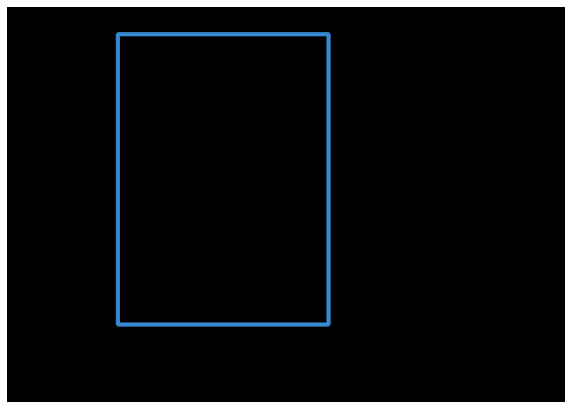

In [37]:
import random as rng

rng.seed(123)

def isInsideRects(rect, rects):
    def isInside(r1, r2):
        (r1_x1, r1_y1, r1_w, r1_h) = r1
        r1_x2, r1_y2 = r1_x1 + r1_w, r1_y1 + r1_h
        (r2_x1, r2_y1, r2_w, r2_h) = r2
        r2_x2, r2_y2 = r2_x1 + r2_w, r2_y1 + r2_h
        return r1_x1 < r2_x1 < r2_x2 < r1_x2 and r1_y1 < r2_y1 < r2_y2 < r1_y2
    for r in rects:
        if isInside(r, rect):
            return True
    return False


img = cv.Canny(r, 100, 100)
MIN_SIZE = 10
ret,thresh = cv.threshold(img,200,200,0)
contours,hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO

# Get rects
tmp_rects = []
colors = []
drawing = np.zeros((img.shape[0],img.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cnt = contours[i]
    x,y,w,h = cv.boundingRect(cnt)
    rect = (x, y, w, h)
    if (w < MIN_SIZE or h < MIN_SIZE):
        continue
    #cv.drawContours(drawing, contours, i, color)
    tmp_rects.append(rect)
    colors.append(color)
    #cv.drawContours(drawing, hulls, i, color)

tmp_rects.sort(key=lambda rect: rect[2] * rect[3], reverse=True)
rects = []
for rect in tmp_rects:
    if not isInsideRects(rect, rects):
        rects.append(rect)

for i in range(len(rects)):
    x, y, w, h = rects[i]
    color = colors[i]
    cv.rectangle(drawing,(x,y),(x+w,y+h),color,2)

displayImage(drawing)